# Project name:Household electricity consumption forecasting

submitted by: Susanta Adhikary

# Problem statement

 project is focused on leveraging Python for time series prediction of household
electricity consumption. The dataset includes essential features such as date, time, global active
power, global reactive power, voltage, global intensity, and sub-metering values. The objective is to
build robust time series forecasting models that can accurately predict future electricity
consumption trends based on historical data. The insights derived from this analysis can empower
households to optimize energy usage, plan efficiently, and contribute to sustainable energy
practices

In [ ]:
#Import packages
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns
sns.set_context('paper',font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

**Read Data**

In [ ]:
from google.colab import drive

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/electricity_consumption_time_series/household_power_consumption_1.txt",sep=";")

In [ ]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [ ]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,26/11/2010,20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,26/11/2010,21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,26/11/2010,21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000
2075258,26/11/2010,21:02:00,0.9320,0.0000,239.5500,3.8000,0.0000,0.0000,0.0000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Feature Engineering

In [ ]:
# Convert features for better analysis
df['date_time']=pd.to_datetime(df['Date']+' '+df['Time'])
df['Global_active_power']=pd.to_numeric(df['Global_active_power'],errors='coerce')
df=df.dropna(subset=['Global_active_power'])

df['date_time']=pd.to_datetime(df['date_time'])
df=df.loc[:,['date_time','Global_active_power']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)

In [ ]:
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
df["weekday"]=(df['weekday']<5).astype(int)


print('Number of rows and columns after removing missing values:',df.shape)
print('The time series starts from:',df['date_time'].min())
print('The time series ends on:',df['date_time'].max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from: 2006-12-16 17:24:00
The time series ends on: 2010-12-11 23:59:00


In [ ]:
# Check if data follows normal distribution or not
stat,p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.6f' %(stat,p))
alpha=0.05
if p>alpha :
  print('Data looks Gaussian(fail to reject H0)')
else:
  print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000000
Data does not look Gaussian (reject H0)


In [ ]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date_time            datetime64[ns]
 1   Global_active_power  float64       
 2   year                 int64         
 3   quarter              int64         
 4   month                int64         
 5   day                  int64         
 6   weekday              int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 109.4 MB


,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0
5,2006-12-16 17:29:00,3.5200,2006,4,12,16,0
6,2006-12-16 17:30:00,3.7020,2006,4,12,16,0
7,2006-12-16 17:31:00,3.7000,2006,4,12,16,0
8,2006-12-16 17:32:00,3.6680,2006,4,12,16,0
9,2006-12-16 17:33:00,3.6620,2006,4,12,16,0


# EDA (exploratory data analysis)

Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320832


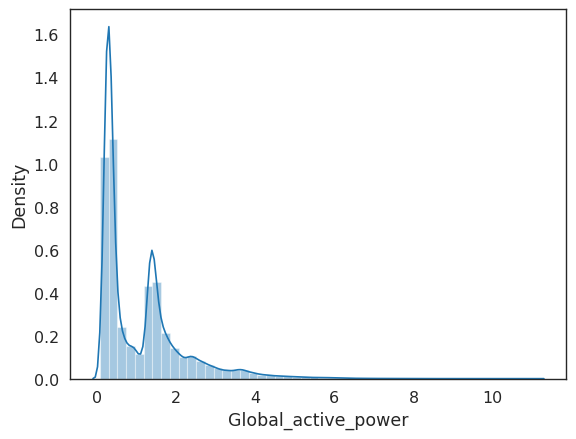

In [ ]:
# check Kurtosis and skewness
sns.distplot(df.Global_active_power)
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

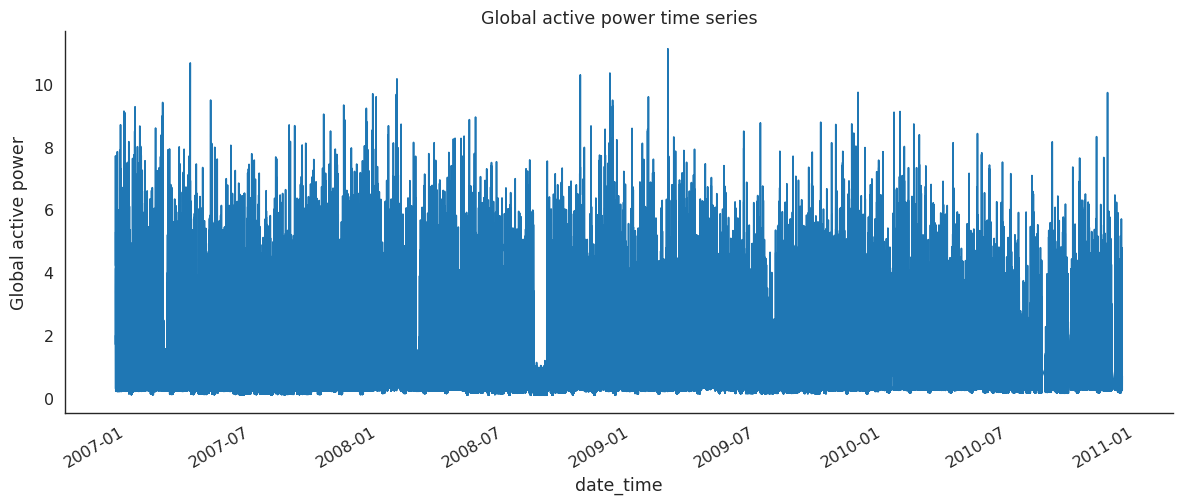

In [ ]:
# Draw time series plot
df1=df.loc[:,['date_time' ,'Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global active power time series')
sns.despine(top=True)
plt.show()

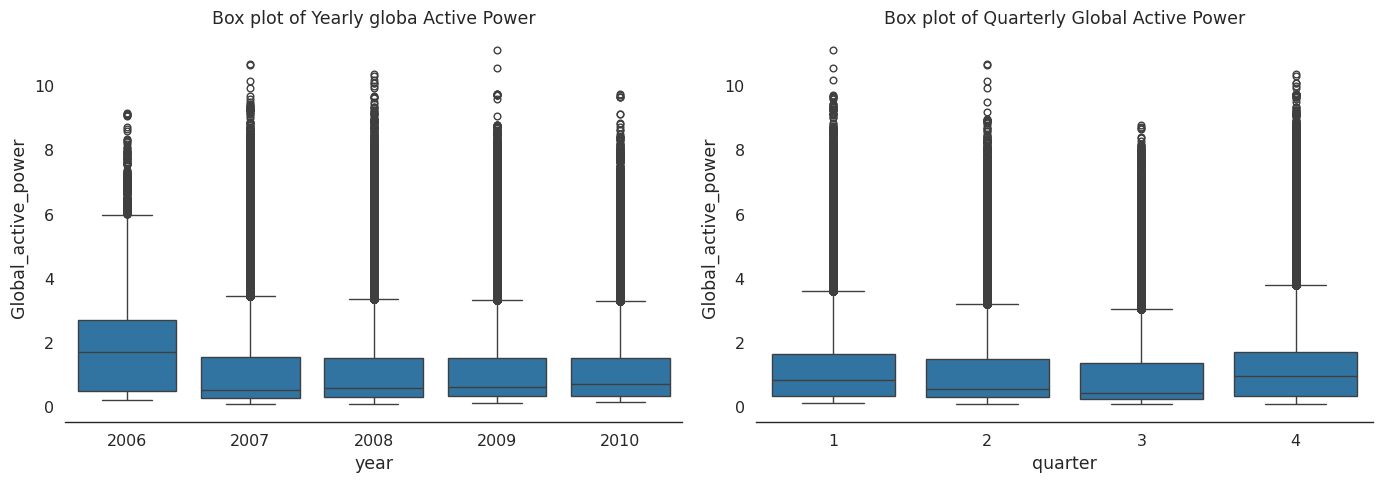

In [ ]:
# Box plot of yearly vs quartly global active power
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year', y='Global_active_power',data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly globa Active Power')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x='quarter',y='Global_active_power',data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


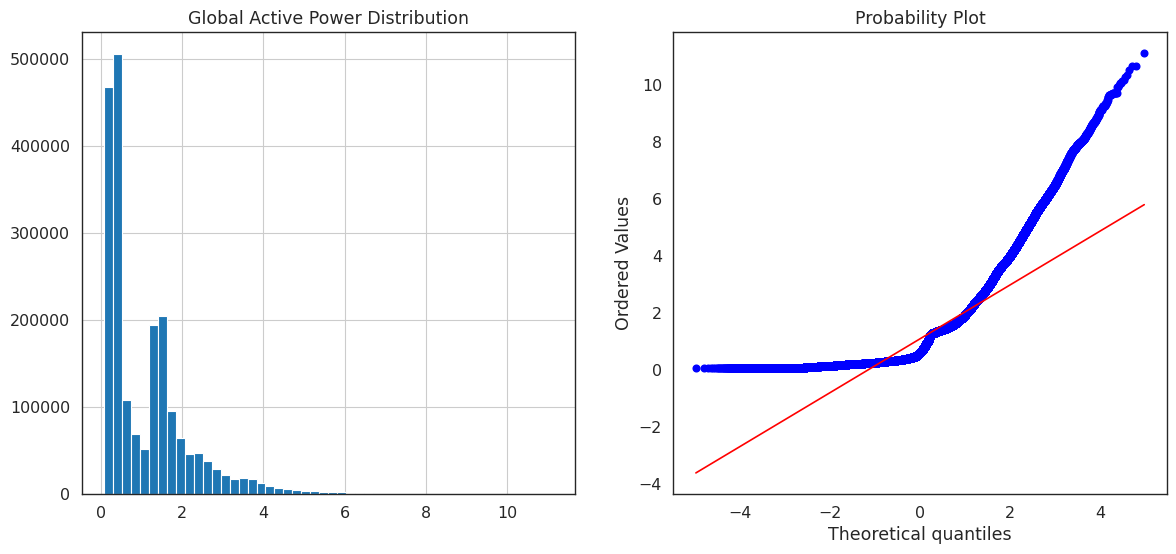

In [ ]:
# Check the distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'],plot=plt)
df1.describe().T

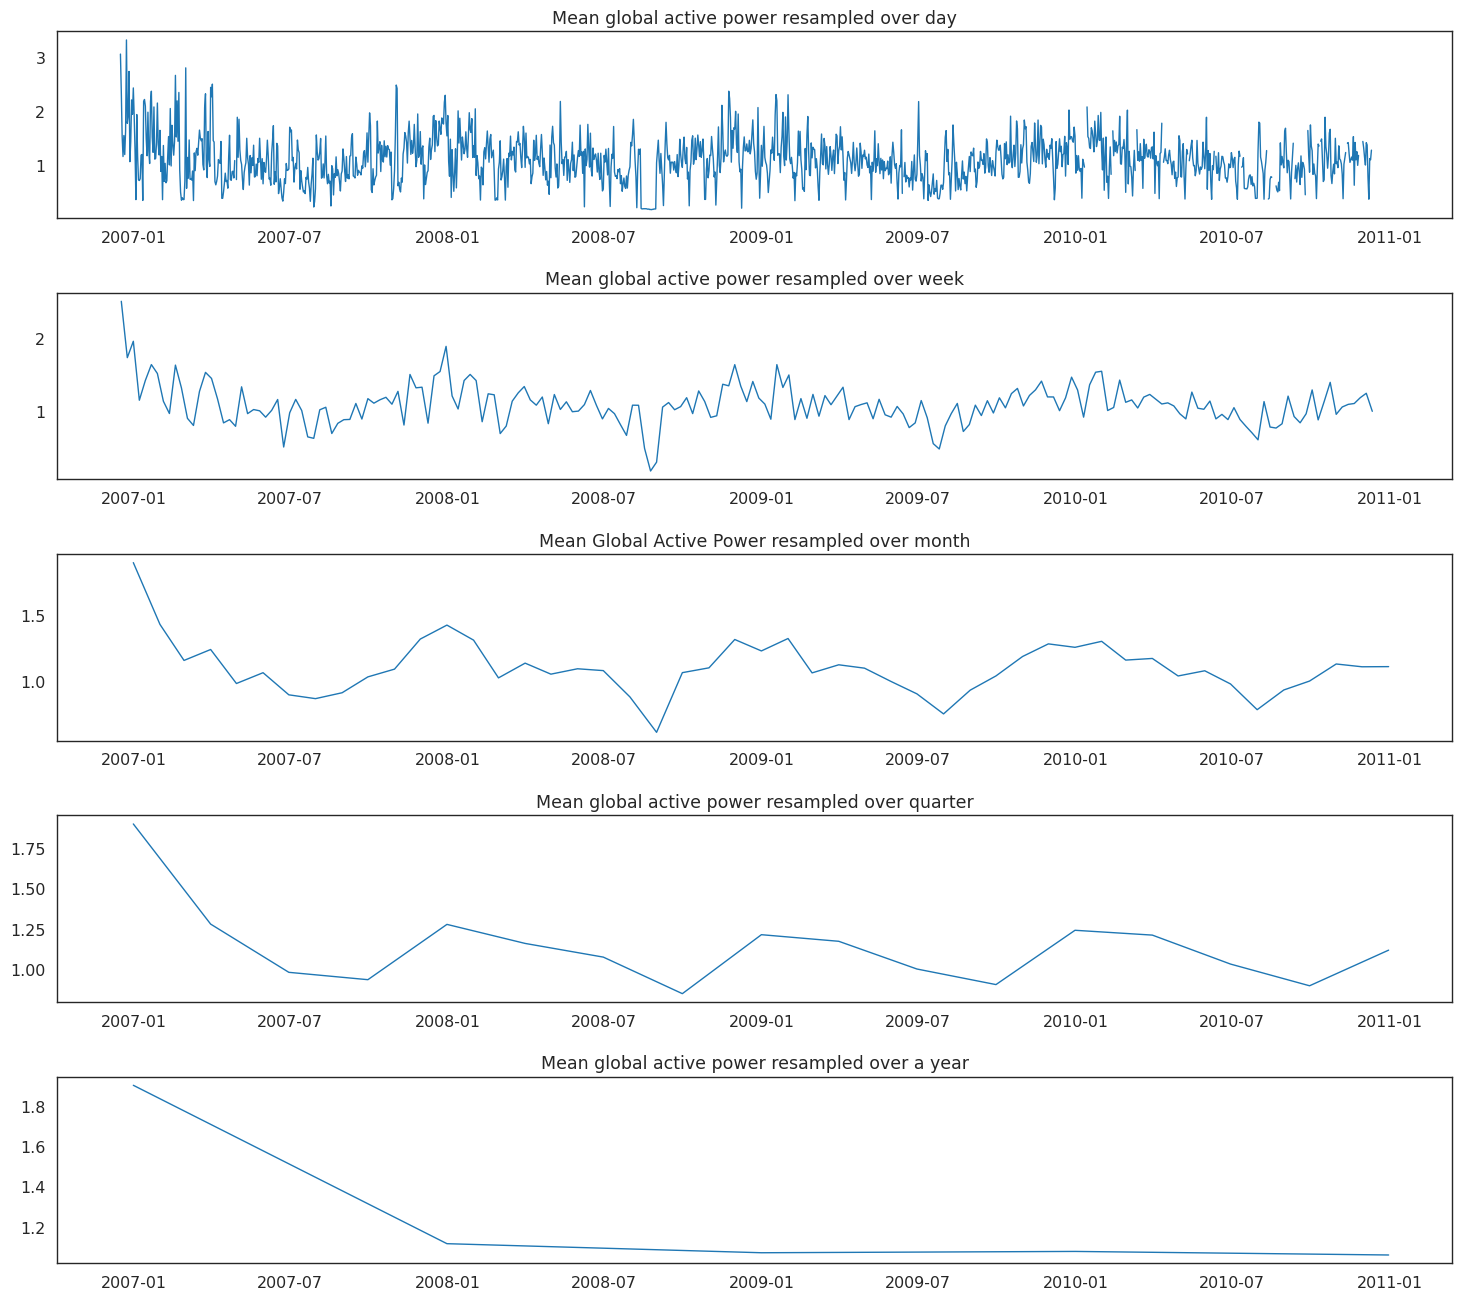

In [ ]:
# Plot average global active power resampled over day,week,month quarter and year
fig=plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=0.4)
ax1=fig.add_subplot(4,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean global active power resampled over day')
ax1.tick_params(axis='both',which='major')

ax2=fig.add_subplot(5,1,2,sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean global active power resampled over week')
ax2.tick_params(axis='both',width='major')

ax3=fig.add_subplot(5,1,3,sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title("Mean Global Active Power resampled over month")
ax3.tick_params(axis='both',which='major')

ax4=fig.add_subplot(5,1,4,sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean global active power resampled over quarter')
ax4.tick_params(axis='both',which='major')

ax5=fig.add_subplot(5,1,5,sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean global active power resampled over a year')
ax5.tick_params(axis='both',which='major')

 The time series has no upward or downward trend. The highest average power consumption seems to be prior to 2007 and thats because we only have december data for 2007. December is winter month and its expected to have power consumption increased.

Text(0.5, 1.0, 'Mean global active power by day')

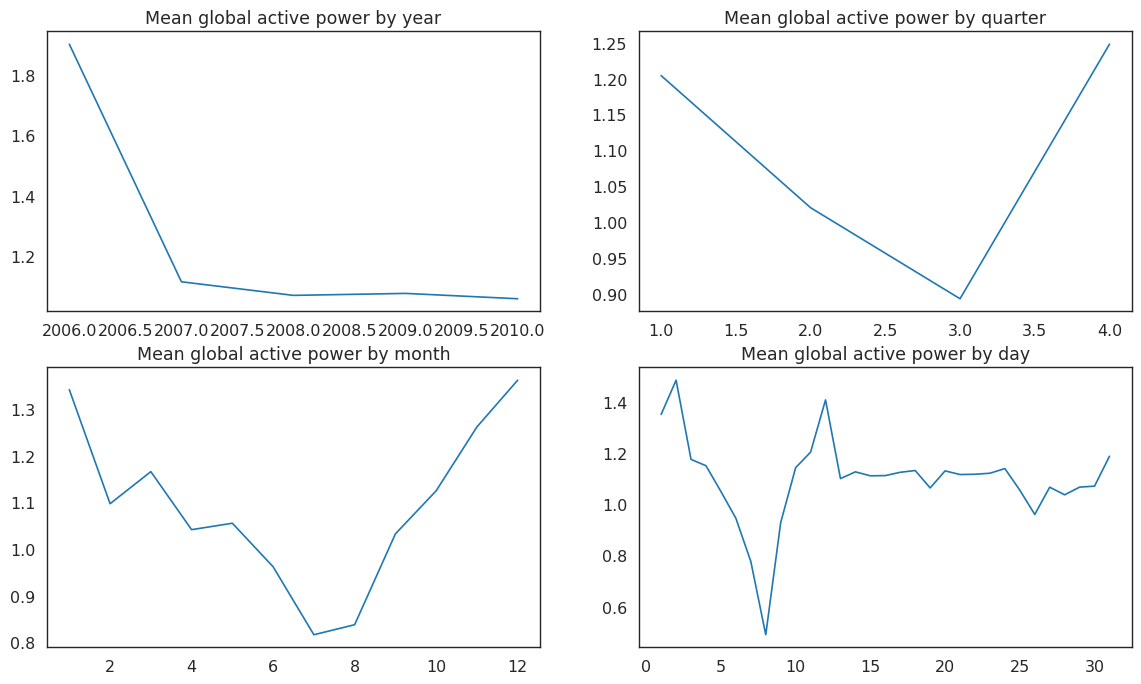

In [ ]:
# Plot mean global active power grouped by year, quarter,monh and day

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean global active power by day')

By year , power is steady after 2007 by month , power is lowest in 7th month by day power is lowest on 8th of every month by quarter, its lowest on 3rd quarter

array([[<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>]], dtype=object)

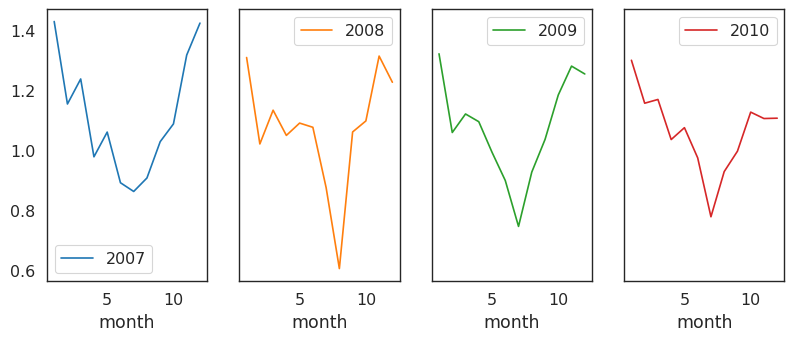

In [ ]:
#We remove 2006 because other years have similar pattern.
pd.pivot_table(df.loc[df['year']!=2006],values='Global_active_power',columns='year',index='month').plot(subplots=True,figsize=(12,12),layout=(3,5),sharey=True)

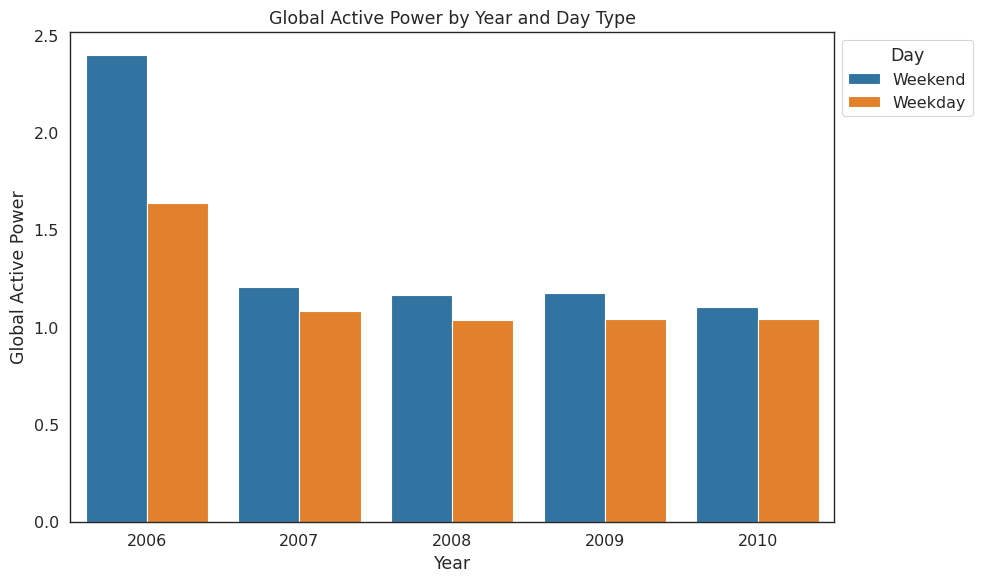

In [ ]:
# Check power consumption during weekdays and weekends

import seaborn as sns
import matplotlib.pyplot as plt

# Create a clustered bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='year', y='Global_active_power', hue='Day', ci=None)

# Adjust plot aesthetics
plt.xlabel('Year')
plt.ylabel('Global Active Power')
plt.title('Global Active Power by Year and Day Type')
plt.legend(title='Day', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# Corrected line


In [ ]:
df.head()

,date_time,Global_active_power,year,quarter,month,day,weekday,Day
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0,Weekend
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0,Weekend
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0,Weekend
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0,Weekend
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0,Weekend


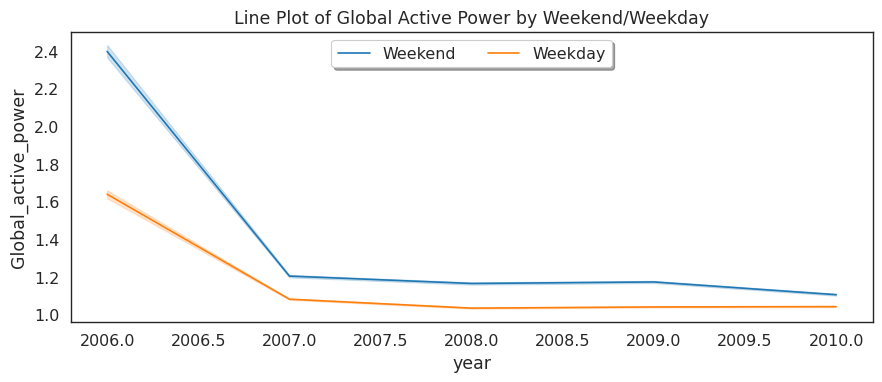

In [ ]:
# Alternative code for line plot of global active power by weekday vs weekend

# Create the line plot using seaborn's lineplot
plt.figure(figsize=(9, 4))
plt1 = sns.lineplot(x='year', y='Global_active_power', hue='Day', data=df)

# Set the title and adjust layout
plt.title('Line Plot of Global Active Power by Weekend/Weekday')
plt.tight_layout()

# Show legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), shadow=True, ncol=2)
plt.show()




**Check if data is stationary or not use Dickey-Fuller test**

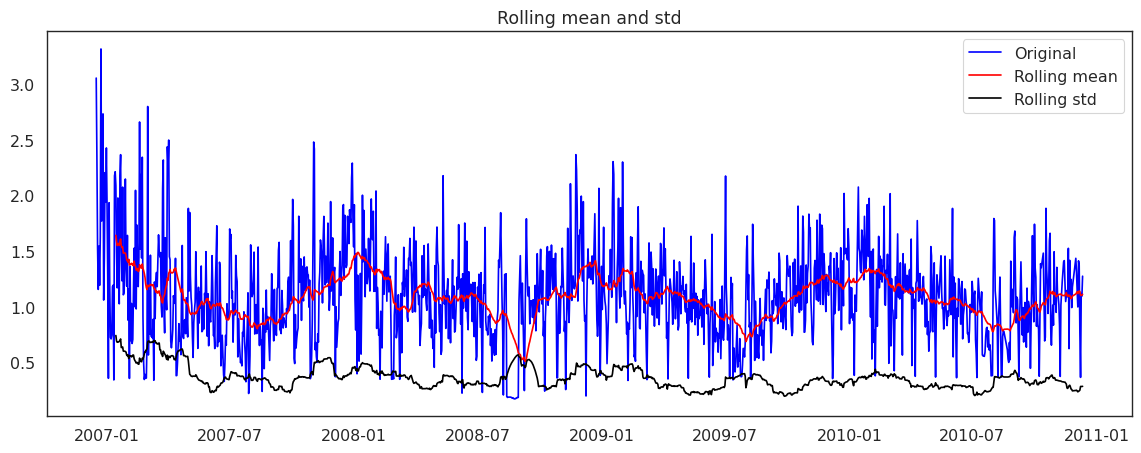

<Results of Dickey Fuller Test>
Test stastic                    -8.3277
p-value                          0.0000
#Lags Used                       9.0000
Number of observations used   1423.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [ ]:
df2=df1.resample('D').mean()

def test_stationarity(timeseries):
  rolmean=timeseries.rolling(window=30).mean()
  rolstd=timeseries.rolling(window=30).std()

  plt.figure(figsize=(14,5))
  sns.despine(left=True)
  orig=plt.plot(timeseries,color='blue',label='Original')
  mean=plt.plot(rolmean,color='red',label='Rolling mean')
  std=plt.plot(rolstd, color='black',label='Rolling std')

  plt.legend(loc='best')
  plt.title('Rolling mean and std')
  plt.show()

  print('<Results of Dickey Fuller Test>')
  dftest=adfuller(timeseries,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],
                     index=['Test stastic','p-value','#Lags Used','Number of observations used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]=value
  print(dfoutput)

test_stationarity(df2.Global_active_power.dropna())

#  Implement LSTM(Long Short-Term Memory)

In [ ]:
# Use LSTM model to predict
# Convert all data to float
# Normalize the featue
# Convert array into matrix
# Reshape into x=t and y=t+1
# reshape input to be 3D(samples, timesteps, features)

dataset=df.Global_active_power.values
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size
train,test =dataset[0:train_size,:],dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
  x,y=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    x.append(a)
    y.append(dataset[i+look_back,0])
  return np.array(x),np.array(y)

look_back=30

x_train,y_train=create_dataset(train,look_back)
x_test,y_test=create_dataset(test,look_back)

# Reshape inputs
x_train= np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

In [ ]:
# Train the model
model=tf.keras.Sequential()
model.add(LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(x_train,y_train, epochs=20, batch_size=70,validation_data=(x_test,y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/20
23420/23420 [==============================] - 78s 3ms/step - loss: 8.0724e-04 - val_loss: 4.2481e-04
Epoch 2/20
23420/23420 [==============================] - 71s 3ms/step - loss: 6.8056e-04 - val_loss: 4.5598e-04
Epoch 3/20
23420/23420 [==============================] - 70s 3ms/step - loss: 6.5459e-04 - val_loss: 4.6001e-04
Epoch 4/20
23420/23420 [==============================] - 67s 3ms/step - loss: 6.4368e-04 - val_loss: 4.5031e-04
Epoch 5/20
23420/23420 [==============================] - 68s 3ms/step - loss: 6.3914e-04 - val_loss: 4.3331e-04
Epoch 6/20
23420/23420 [==============================] - 71s 3ms/step - loss: 6.3616e-04 - val_loss: 4.3205e-04
Epoch 7/20
23420/23420 [==============================] - 71s 3ms/step - loss: 6.3338e-04 - val_loss: 4.3048e-04
Epoch 8/20
23420/23420 [==============================] - 67s 3ms/step - loss: 6.3204e-04 - val_loss: 4.1938e-04
Epoch 9/20
23420/23420 [==============================] - 67s 3ms/step - loss: 6.3184e-04 - val_

# PREDICTION

In [ ]:
#Make predictions

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

12808/12808 [==============================] - 15s 1ms/step
Train Mean Absolute Error: 0.10773618847785194
Train Root Mean Squared Error: 0.2661712872620316
Test Mean Absolute Error: 0.09324741153632123
Test Root Mean Squared Error: 0.22075626747234597


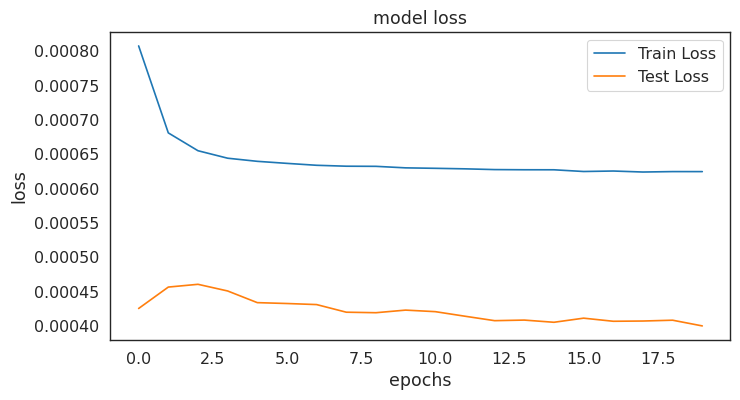

In [ ]:
#plot model losses
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

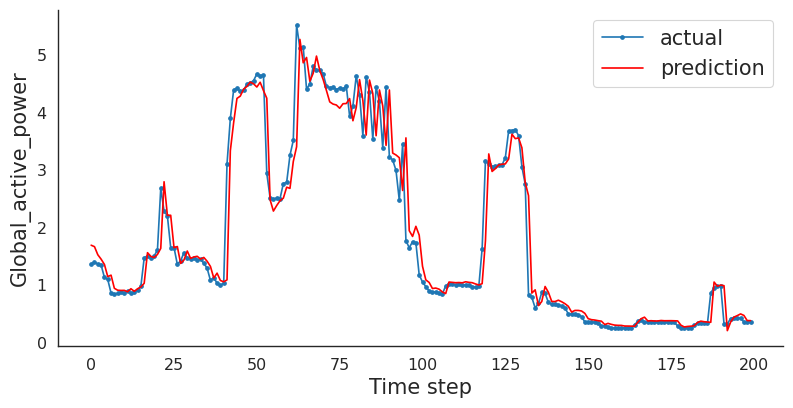

In [ ]:
#Compare actual vs predicted for last 200 minutes

aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Conclusion



*   After analyzing this dataset we have predict the time series forcast using LSTM.
*   After performation EDA(exploratory data analysis)we have to seen trends of power usages in household .

*   The time series has no upward or downward trend. The highest average power consumption seems to be prior to 2007 and thats because we only have december data for 2007. December is winter month and its expected to have power consumption increased.
*  We analyze that by year , power is steady after 2007 by month , power is lowest in 7th month by day power is lowest on 8th of every month by quarter, its lowest on 3rd quarter.


*   Also we check which years weeks and weekends consume more energy.
*   We use dickey fuller test to check  
data is is stationary or not.

*   After we implement LSTM for forecasting and we get a good resut from it.







